In [2]:
import intel_extension_for_pytorch as ipex

In [3]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch import optim
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict
from tqdm import tqdm
%matplotlib inline

### Dataset

In [4]:
trainset = FashionMNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
testset = FashionMNIST(root='../data', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:07<00:00, 3612982.20it/s]


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 303249.37it/s]


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3617533.42it/s]


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [4]:
classes = {i : name for i, name in enumerate(trainset.classes)}
classes

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

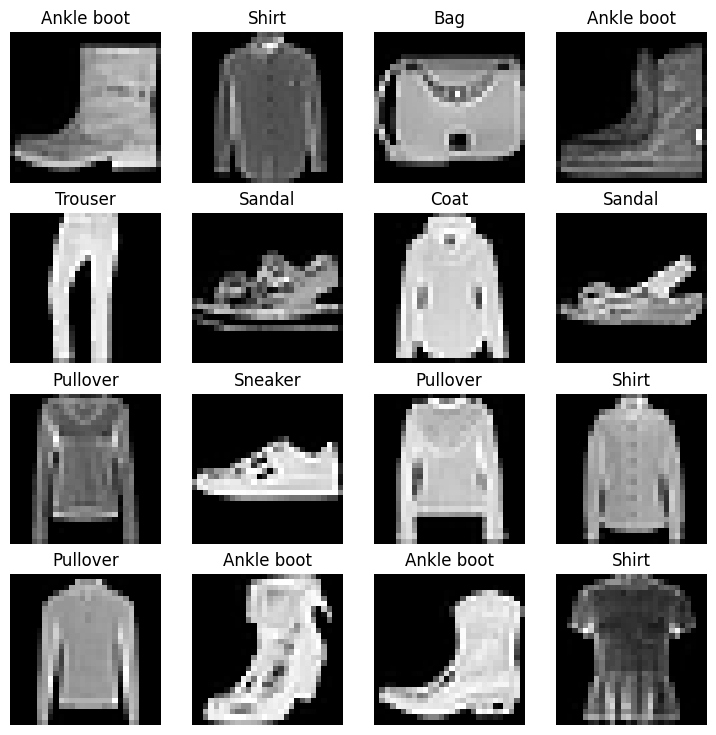

In [5]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    idx = torch.randint(0, len(trainset), size=[1]).item()
    img, label = trainset[idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(classes[label])
    plt.axis(False)

In [6]:
BATCH_SIZE = 16
NUM_WORKERS = 4
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
testloader  = DataLoader(dataset= testset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
imgs, labels = next(iter(trainloader))

### Variational Autoencoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_shape: int, hidden_units:Tuple=(32, 64, 128)) -> None:
        super(Encoder, self).__init__()
        assert len(hidden_units) == 3, "hidden_units must be 3 dimensional"
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                        out_channels=hidden_units[0],
                        kernel_size=3,
                        padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=hidden_units[0],
                        out_channels=hidden_units[1],
                        kernel_size=3,
                        padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=hidden_units[1],
                        out_channels=hidden_units[2],
                        kernel_size=3,
                        padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.conv_block(input)
        self.out_shape = out.shape[1:]
        out = nn.Flatten()(out)
        return out

In [8]:
class LatentSpace(nn.Module):
    def __init__(self, in_features: int, dims: int) -> None:
        super(LatentSpace, self).__init__()
        self.dims = dims
        self.z_mean_layer = nn.Linear(in_features=in_features,out_features=dims)
        self.z_log_var_layer = nn.Linear(in_features=in_features, out_features=dims)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        z_mean = self.z_mean_layer(input)
        z_log_var = self.z_log_var_layer(input)
        z_sigma = (z_log_var * 0.5).exp()
        eps = torch.randn_like(z_sigma)
        z = z_mean + z_sigma * eps
        return z_mean, z_log_var, z

In [9]:
class Decoder(nn.Module):
    def __init__(self, dims: int, enc_shape: Tuple, hidden_units:Tuple=(32, 64, 128)) -> None:
        super(Decoder, self).__init__()
        self.convt_block = nn.Sequential(
            nn.Linear(in_features=dims, out_features=np.prod(enc_shape)),
            nn.Unflatten(dim=1, unflattened_size=enc_shape),
            nn.ConvTranspose2d(in_channels=hidden_units[-1],
                               out_channels=hidden_units[-2],
                               kernel_size=3,
                               stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_units[-2],
                               out_channels=hidden_units[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_units[-1],
                               out_channels=1,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            # decoder output
            nn.Conv2d(in_channels=1,
                      out_channels=1,
                      kernel_size=3,
                      padding='same'),
            nn.Sigmoid())

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.convt_block(input)

In [10]:
class ConditionalVAE(nn.Module):
    def __init__(self, encoder, decoder, latentspace, classes: Dict) -> None:
        super(ConditionalVAE, self).__init__()
        self.classes = classes

        self.encoder = encoder
        self.decoder = decoder
        self.latentspace = latentspace
        self.cls_embedding = nn.Embedding(len(classes), latentspace.dims)
        # self.cls_linear = nn.Linear(len(classes), self.latentspace.dims)

    def forward(self, imgs: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        enc_out = self.encoder(imgs)
        z_mean, z_log_var, z = self.latentspace(enc_out)
        dec_in = z + self.cls_embedding(labels)
        dec_out = self.decoder(dec_in)
        return z_mean, z_log_var, dec_out

    def generate(self, labels: torch.Tensor) -> torch.Tensor:
        cls_projection = self.cls_embedding(labels)
        z = torch.randn_like(cls_projection)
        return self.decoder(z + cls_projection)

### Training

In [11]:
def loss_fn(reconstruction, original, z_mean, z_log_var):
    BCE = nn.BCELoss(reduction='mean')(reconstruction, original)
    KLD = -0.5 * (1 + z_log_var - z_mean ** 2 - z_log_var.exp()).mean()
    total = BCE + KLD
    return BCE, KLD, total

def update_results(storage: Dict, results: Dict):
    for key in results:
        storage[key].append(results[key])

def show_imgs(imgs, labels):
    # imgs, labels = imgs.to('cpu').detach().numpy(), labels.to('cpu').detach().numpy()
    fig = plt.figure(figsize=(8,4))
    rows, cols = 2, 4
    for i in range(rows*cols):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(imgs[i].squeeze(), cmap='gray')
        plt.title(classes[labels[i].item()])
        plt.axis(False)
    plt.show();

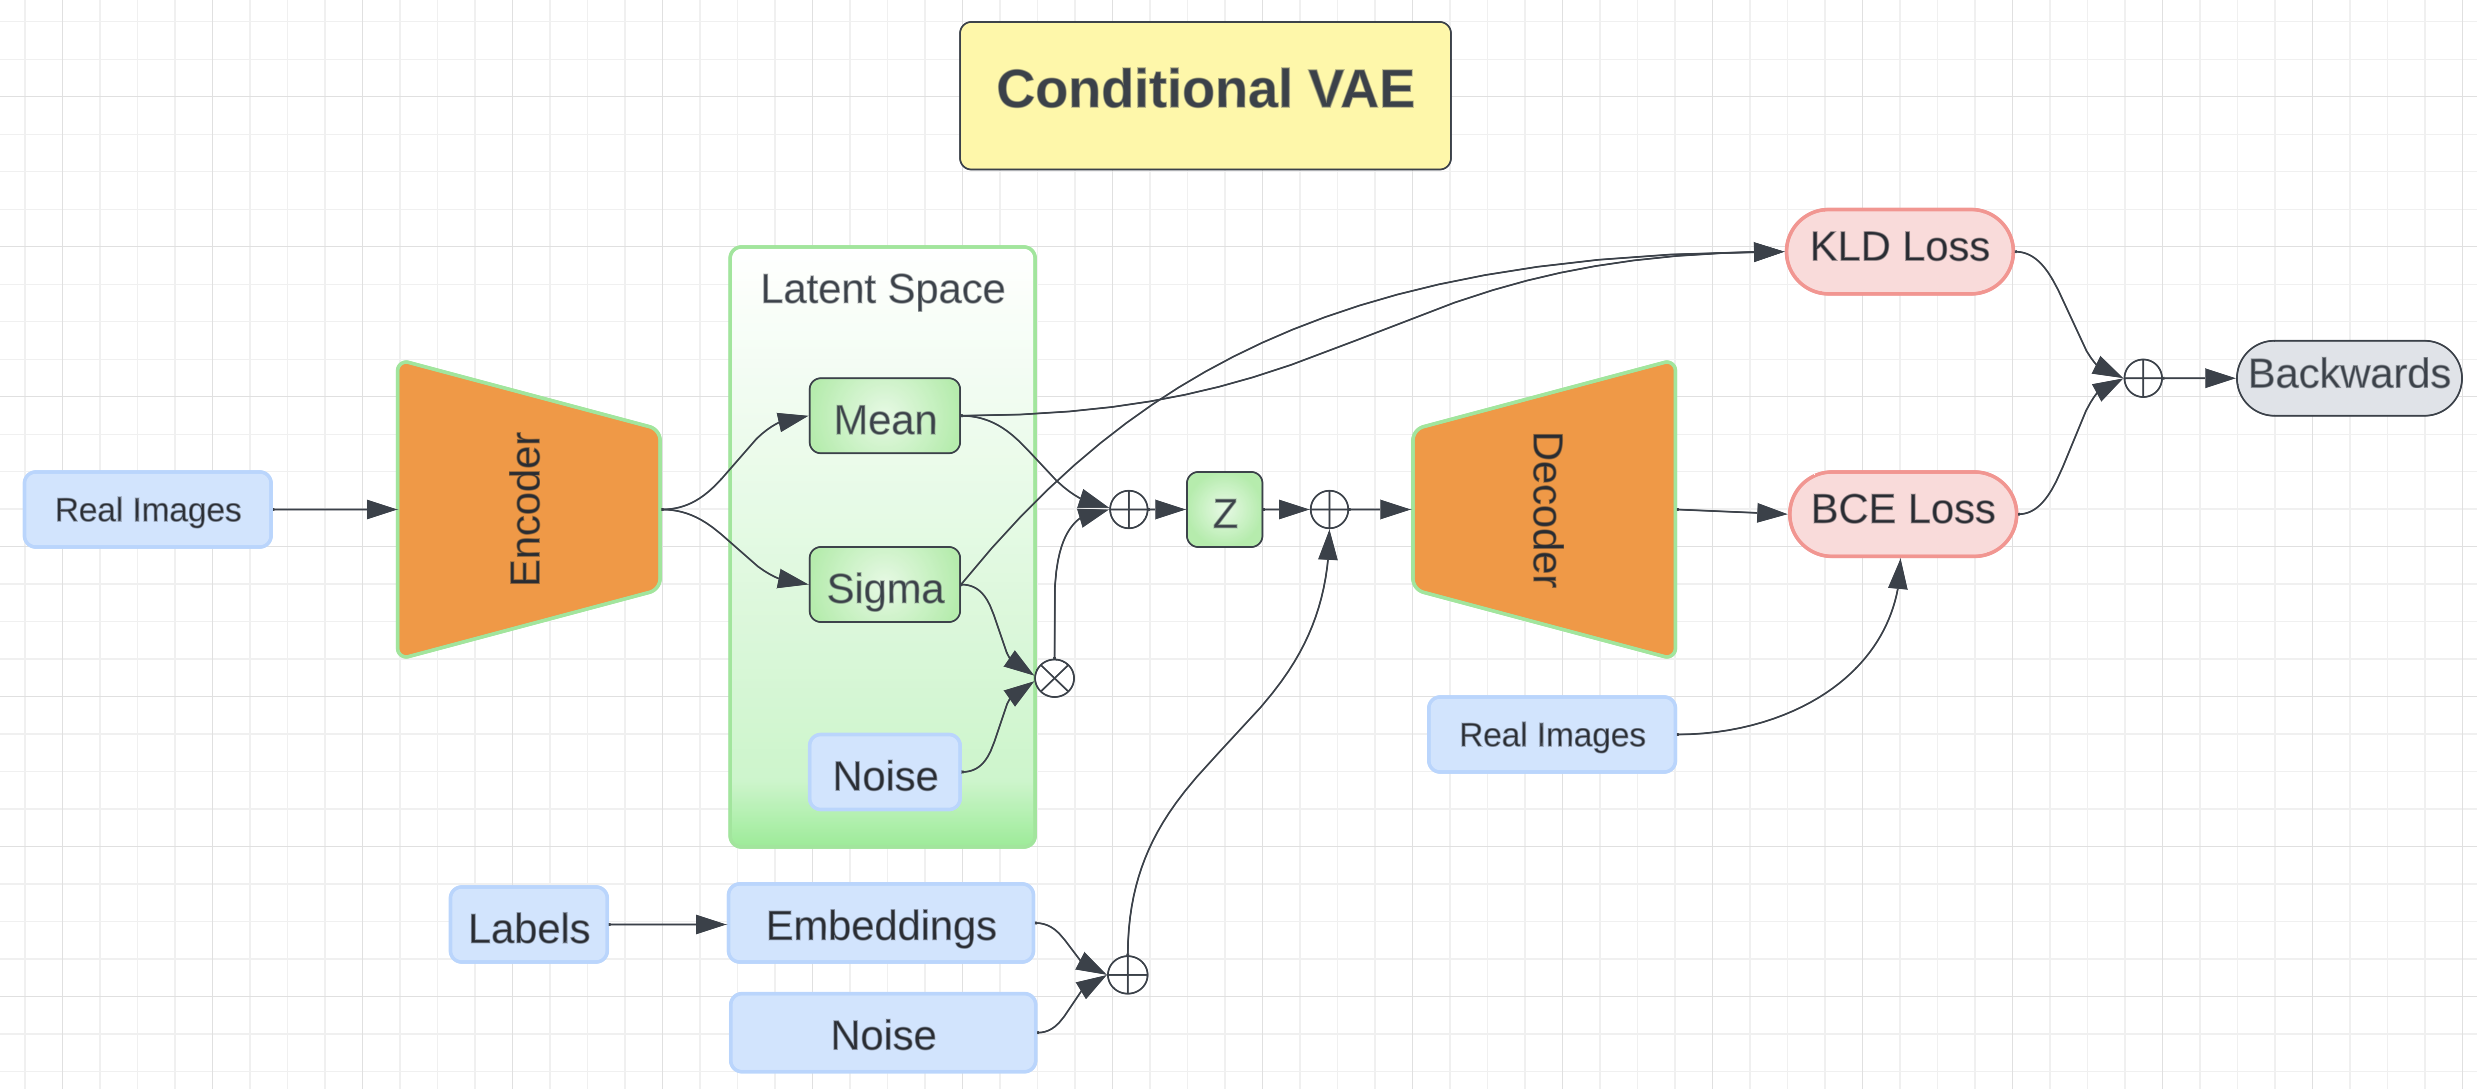

In [12]:
def train_step(model: nn.Module, dataloader: DataLoader,
               loss_fn: callable, optimizer: optim.Optimizer,
               device: torch.device, metric_fn: callable) -> Dict:

    model.train()
    model, optimizer = ipex.optimize(model, optimizer=optimizer)
    total_loss, bce_loss, kld_loss, metric = .0, .0, .0, .0

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)
        z_mean, z_log_var, reconstruction = model(X, y)

        bce, kld, batch_loss = loss_fn(reconstruction, X, z_mean, z_log_var)

        total_loss += batch_loss.item()
        bce_loss += bce.item()
        kld_loss += kld.item()
        # metric += ...

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_loss /= len(dataloader)
    bce_loss /= len(dataloader)
    kld_loss /= len(dataloader)
    metric /= len(dataloader)

    return {'total_loss': total_loss,
            'bce_loss': bce_loss,
            'kld_loss': kld_loss,
            'metric': metric}


def test_step(model: nn.Module, dataloader: DataLoader,
              loss_fn: callable, device: torch.device,
              metric_fn: callable) -> Dict:

    total_loss, bce_loss, kld_loss, metric = .0, .0, .0, .0

    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            z_mean, z_log_var, reconstruction = model(X, y)
            bce, kld, batch_loss = loss_fn(reconstruction, X, z_mean, z_log_var)

            total_loss += batch_loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

    total_loss /= len(dataloader)
    bce_loss /= len(dataloader)
    kld_loss /= len(dataloader)
    metric /= len(dataloader)

    return {'total_loss': total_loss,
            'bce_loss': bce_loss,
            'kld_loss': kld_loss,
            'metric': metric}


def train(model: nn.Module, train_dataloader: DataLoader,
          test_dataloader: DataLoader, loss_fn: callable,
          optimizer: optim.Optimizer, device: torch.device,
          EPOCHS: int, metric_fn: callable):

    model = model.to(device)

    columns = ['total_loss', 'bce_loss', 'kld_loss', 'metric']
    train_results = {key:[] for key in columns}
    test_results = {key:[] for key in columns}
    
    for epoch in range(EPOCHS):
        
        print(f"Epoch {epoch + 1}/{EPOCHS} - Training:")

        results = train_step(model, train_dataloader, loss_fn,
                                  optimizer, device, metric_fn)

        update_results(train_results, results)
        print(f"  Train Loss: {results['total_loss']:.4f}")

        print("  Testing:")
        results = test_step(model, test_dataloader, loss_fn,
                                 device, metric_fn)

        update_results(test_results, results)
        print(f"  Test Loss: {results['total_loss']:.4f}")
        
        with torch.inference_mode():
            rand_labels = torch.randint(0, 10, (8,)).to(device)
            gen_imgs = model.generate(rand_labels)
            gen_imgs = gen_imgs.to('cpu').detach().numpy()
            rand_labels = rand_labels.to('cpu').detach().numpy()
            show_imgs(gen_imgs, rand_labels)

    return train_results, test_results

In [13]:
print(f"Device: {ipex.xpu.get_device_name()}")

Device: Intel(R) Arc(TM) A770 Graphics


Epoch 1/5 - Training:


  0%|          | 0/3750 [00:00<?, ?it/s]

100%|██████████| 3750/3750 [00:25<00:00, 144.53it/s]


  Train Loss: 0.4118
  Testing:


100%|██████████| 625/625 [00:03<00:00, 196.09it/s]


  Test Loss: 0.4002


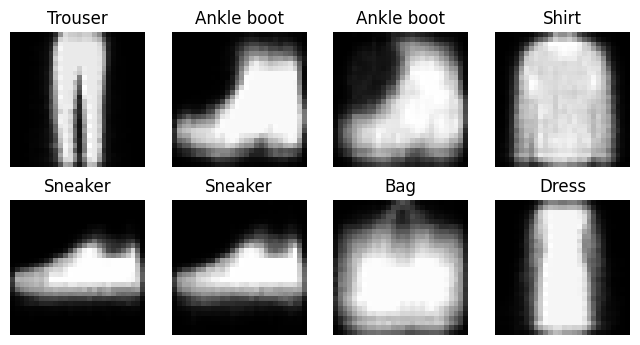

Epoch 2/5 - Training:


100%|██████████| 3750/3750 [00:23<00:00, 158.20it/s]


  Train Loss: 0.3973
  Testing:


100%|██████████| 625/625 [00:02<00:00, 209.10it/s]

  Test Loss: 0.3976


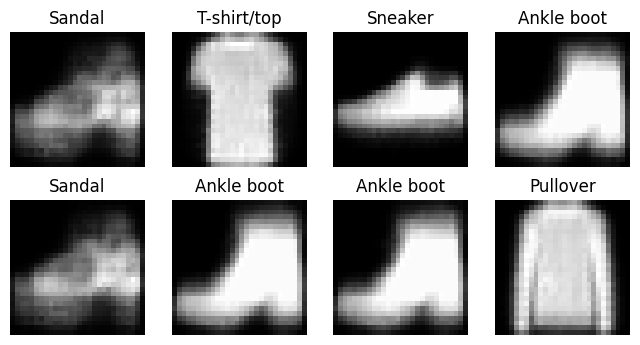

Epoch 3/5 - Training:


100%|██████████| 3750/3750 [00:23<00:00, 161.48it/s]


  Train Loss: 0.3955
  Testing:


100%|██████████| 625/625 [00:02<00:00, 208.66it/s]

  Test Loss: 0.3965


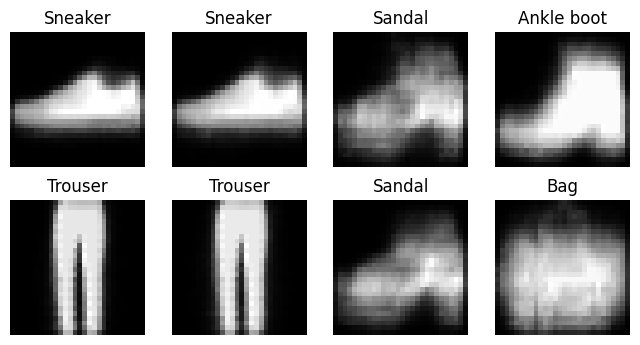

Epoch 4/5 - Training:


100%|██████████| 3750/3750 [00:23<00:00, 158.74it/s]


  Train Loss: 0.3947
  Testing:


100%|██████████| 625/625 [00:02<00:00, 208.34it/s]

  Test Loss: 0.3964


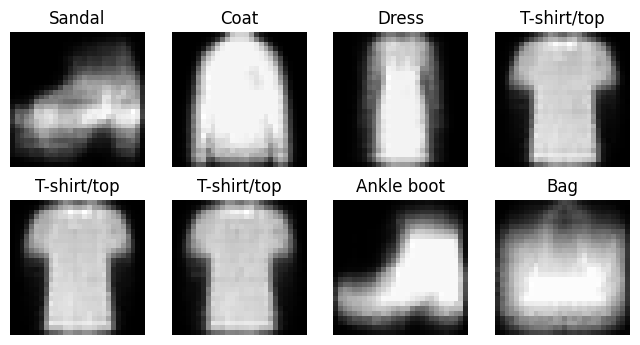

Epoch 5/5 - Training:


100%|██████████| 3750/3750 [00:23<00:00, 161.17it/s]


  Train Loss: 0.3944
  Testing:


100%|██████████| 625/625 [00:02<00:00, 208.85it/s]

  Test Loss: 0.3960


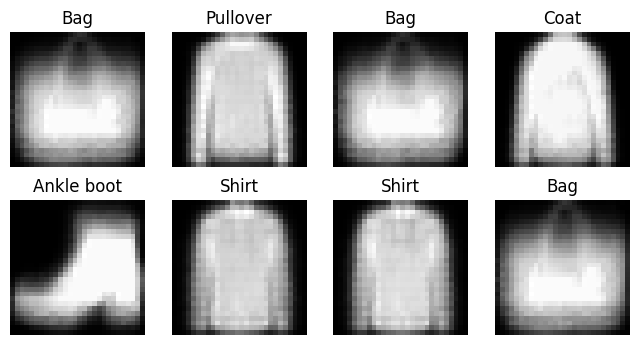

In [14]:
device = 'xpu' if ipex.xpu.is_available() else 'cpu'

LATENT_DIMS = 8
EPOCHS = 5

encoder = Encoder(1)
enc = encoder(imgs)
latentspace = LatentSpace(np.prod(encoder.out_shape), LATENT_DIMS)
decoder = Decoder(LATENT_DIMS, encoder.out_shape)
cvae = ConditionalVAE(encoder, decoder, latentspace, classes)
optimizer = optim.Adam(cvae.parameters())
metric_fn = lambda x: x # identity metric
results = train(cvae, trainloader, testloader, loss_fn, optimizer, device, EPOCHS, metric_fn)

In [15]:
train_results, test_results = results

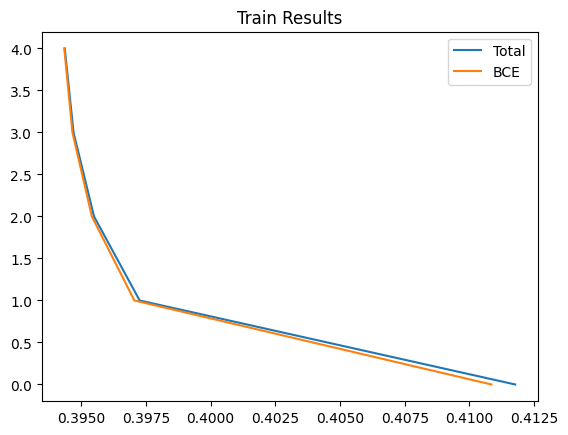

In [16]:
plt.plot(train_results["total_loss"], range(EPOCHS), label='Total')
plt.plot(train_results['bce_loss'], range(EPOCHS), label='BCE')
plt.legend()
plt.title("Train Results");

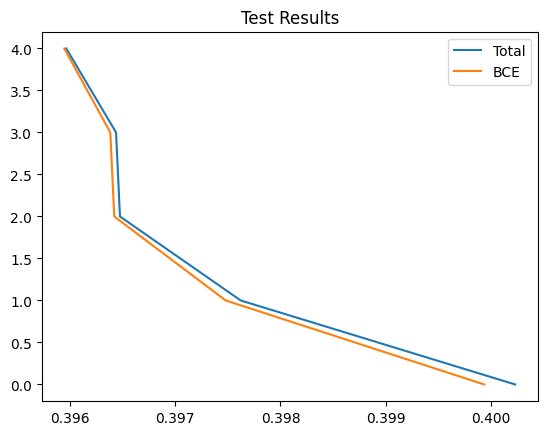

In [17]:
plt.plot(test_results["total_loss"], range(EPOCHS), label='Total')
plt.plot(test_results['bce_loss'], range(EPOCHS), label='BCE')
plt.legend()
plt.title('Test Results');